# Importing Librarires 

In [1]:
# Libraries and dependencies:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, roc_curve ,auc, precision_score,recall_score
from sklearn.utils import resample,shuffle
from imblearn.over_sampling import SMOTE,RandomOverSampler,SMOTEN
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Exploratory Data Analysis:

In [2]:
# importing Dataset:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
id,5110.0,36517.829354,21161.721625,67.00,17741.250,36932.000,54682.00,72940.00
age,5110.0,43.226614,22.612647,0.08,25.000,45.000,61.00,82.00
hypertension,5110.0,0.097456,0.296607,0.00,0.000,0.000,0.00,1.00
heart_disease,5110.0,0.054012,0.226063,0.00,0.000,0.000,0.00,1.00
avg_glucose_level,5110.0,106.147677,45.283560,55.12,77.245,91.885,114.09,271.74
bmi,4909.0,28.893237,7.854067,10.30,23.500,28.100,33.10,97.60
stroke,5110.0,0.048728,0.215320,0.00,0.000,0.000,0.00,1.00


In [6]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
df.isnull().sum()/len(df)*100

id                   0.000000
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [8]:
mean_stroke = round(df[df.stroke == 1]['bmi'].mean())
mean_healthy = round(df[df.stroke == 0]['bmi'].mean())
mean_healthy

29

In [9]:
df['bmi'] = np.where((df.bmi.isnull()) & (df.stroke == 1), mean_stroke,df['bmi'])
df['bmi'] = np.where((df.bmi.isnull()) & (df.stroke == 0 ),mean_healthy,df['bmi'])

In [10]:
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
df.gender.value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [12]:
obj_col = df.select_dtypes(include='object')
obj_col.nunique()

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

In [13]:
obj_col[(obj_col.gender != 'Male') & (obj_col.gender != 'Female')]

,gender,ever_married,work_type,Residence_type,smoking_status
3116,Other,No,Private,Rural,formerly smoked


In [14]:
df.drop(df[(df.gender!='Male') & (df.gender != 'Female')].index,inplace=True)

In [15]:
df.shape

(5109, 12)

In [16]:
target_balance = df.stroke.value_counts()
target_balance = pd.DataFrame(target_balance)
print(f"The unbalanced state in terms of percentage, no-stroke: {round(target_balance['count'][0]/len(df),2)*100}%, stroke: {round(target_balance['count'][1]/len(df),2)*100}%")

The unbalanced state in terms of percentage, no-stroke: 95.0%, stroke: 5.0%


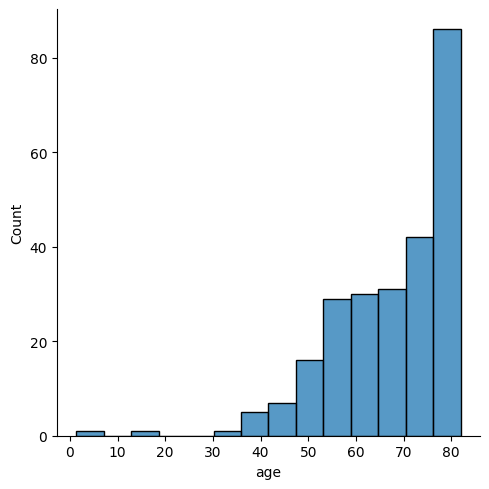

In [17]:
sns.displot(df[df.stroke == 1.0]['age'])

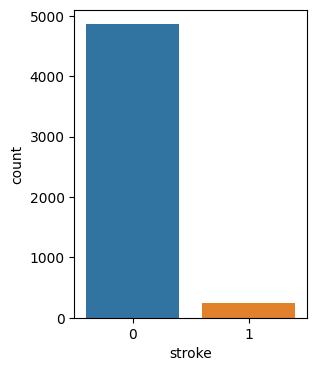

In [18]:
plt.figure(figsize=(3,4))
sns.barplot(data=target_balance,x=target_balance.index,y='count',)
plt.show();

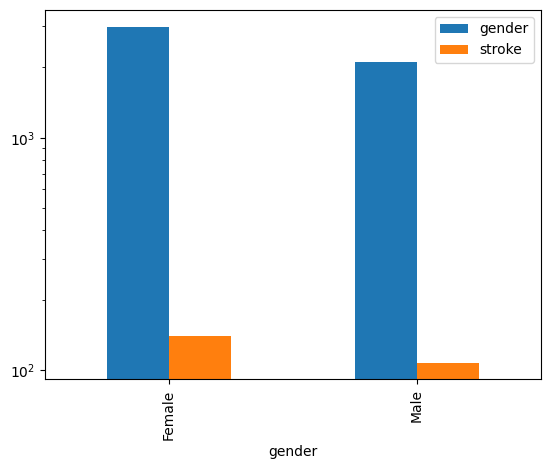

In [19]:
gender_representation = df.groupby('gender').agg({'gender':'count','stroke':'sum'})
gender_representation.plot(kind='bar')
plt.yscale('log')
plt.show();

In [20]:
numerical_data = (df.select_dtypes(exclude='object')).drop(columns = ['id','hypertension','heart_disease','stroke'])

In [21]:
numerical_data['stroke'] = df['stroke']

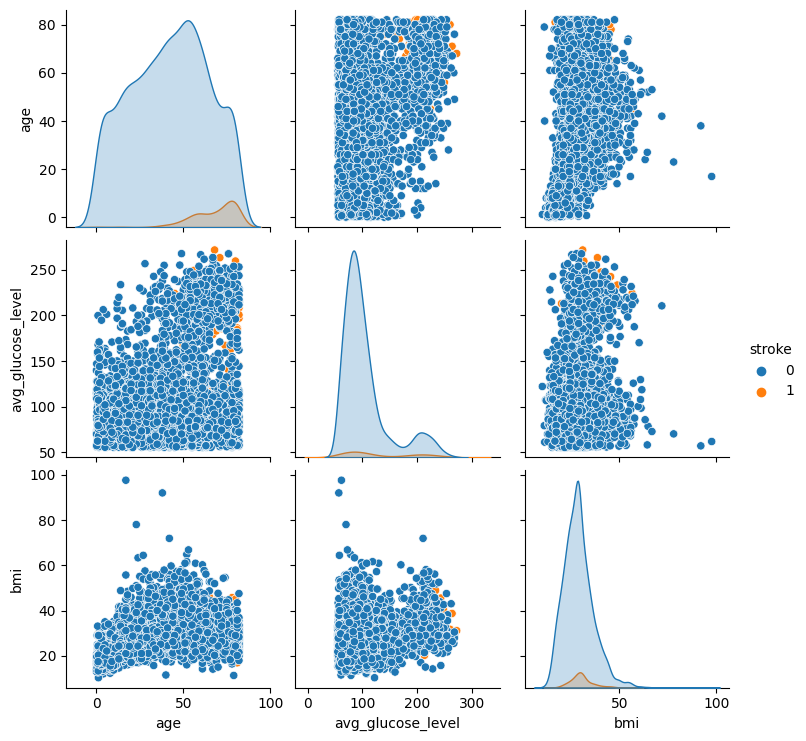

In [22]:
sns.pairplot(numerical_data,hue='stroke',)
plt.show();

# Data Preprocessing:

## Encoding : 

In [23]:
to_encode = df.select_dtypes(include='object')
encode_columns = to_encode.columns

In [24]:
encode_columns

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [25]:
encoder_one_hot = OneHotEncoder(sparse=False,drop='first')
oh_encoded = encoder_one_hot.fit_transform(df[encode_columns])

In [26]:
oh_encoded = pd.DataFrame(oh_encoded,columns = encoder_one_hot.get_feature_names_out(input_features=encode_columns))

In [27]:
df = df.drop(columns=encode_columns)

In [28]:
df_encoded = pd.concat([df,oh_encoded],axis=1,join='inner')
df_encoded.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,51676,61.0,0,0,202.21,30.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,31112,80.0,0,1,105.92,32.5,1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,60182,49.0,0,0,171.23,34.4,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1665,79.0,1,0,174.12,24.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [29]:
df_encoded.shape

(5108, 17)

In [30]:
df_encoded.isna().sum()

id                                0
age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
stroke                            0
gender_Male                       0
ever_married_Yes                  0
work_type_Never_worked            0
work_type_Private                 0
work_type_Self-employed           0
work_type_children                0
Residence_type_Urban              0
smoking_status_formerly smoked    0
smoking_status_never smoked       0
smoking_status_smokes             0
dtype: int64

In [31]:
df_encoded = df_encoded.drop(columns='id')

# Resampling:

In [32]:
df_majority = df_encoded[df_encoded['stroke'] == 0]
df_minority = df_encoded[df_encoded['stroke'] == 1]

In [33]:
# Random oversampling
df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_oversampled = pd.concat([df_majority,df_minority_oversampled])

In [34]:
x,y = df_oversampled.drop(columns='stroke'),df_oversampled['stroke']

In [35]:
y.value_counts()

stroke
0    4859
1    4859
Name: count, dtype: int64

## Scaling:

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)



In [39]:
X_scaled[0]

array([-2.33459916, -0.46029534, -0.37301422, -0.42118948, -1.69197427,
        1.17230439, -1.79333546, -0.04763378, -1.17602334, -0.51481564,
        3.52721096, -1.05894801, -0.53125061, -0.76219013, -0.43862585])

## Training and Testing Sets:

In [40]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.30,stratify=y,random_state=10)

In [41]:
y_train.value_counts() , y_test.value_counts()

(stroke
 1    3401
 0    3401
 Name: count, dtype: int64,
 stroke
 1    1458
 0    1458
 Name: count, dtype: int64)

# Model Selection:

In [42]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [43]:
estimators = [
    ('random_forest', RandomForestClassifier()),
    ('svm', SVC()),
    ('logistic_regression', LogisticRegression()),
    ('Decision_tree',DecisionTreeClassifier()),
    ('SGD', SGDClassifier())
     
]

# Define a parameter grid for each estimator
param_grids = {
    'random_forest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    },
    'logistic_regression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2']
    },
    'Decision_tree': {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'SGD': {
        'loss': ['hinge', 'log', 'perceptron'],
        'penalty': ['l1', 'l2', 'elasticnet']
    }
}

In [45]:
best_models = {}
for name, estimator in estimators:
    grid_search = GridSearchCV(estimator,param_grids[name],scoring =['accuracy','precision','recall'],refit='precision',cv=3,n_jobs=-1)
    grid_search.fit(X_train,y_train)
    best_models[name] = [grid_search.best_estimator_,grid_search.best_score_,grid_search.best_params_]


In [46]:
best_models

{'random_forest': [RandomForestClassifier(max_depth=20, n_estimators=200),
  0.9659614592327465,
  {'max_depth': 20, 'n_estimators': 200}],
 'svm': [SVC(C=10), 0.8363064863920641, {'C': 10, 'kernel': 'rbf'}],
 'logistic_regression': [LogisticRegression(C=0.1),
  0.7630132309547611,
  {'C': 0.1, 'penalty': 'l2'}],
 'Decision_tree': [DecisionTreeClassifier(),
  0.9326035693807917,
  {'max_depth': None, 'min_samples_split': 2}],
 'SGD': [SGDClassifier(penalty='l1'),
  0.765373622192863,
  {'loss': 'hinge', 'penalty': 'l1'}]}

In [47]:
performance = pd.DataFrame(best_models)
performance = performance.T.rename(columns={0:'estimator',1:'score',2:'best_params'})
performance

,estimator,score,best_params
random_forest,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.965961,"{'max_depth': 20, 'n_estimators': 200}"
svm,SVC(C=10),0.836306,"{'C': 10, 'kernel': 'rbf'}"
logistic_regression,LogisticRegression(C=0.1),0.763013,"{'C': 0.1, 'penalty': 'l2'}"
Decision_tree,DecisionTreeClassifier(),0.932604,"{'max_depth': None, 'min_samples_split': 2}"
SGD,SGDClassifier(penalty='l1'),0.765374,"{'loss': 'hinge', 'penalty': 'l1'}"


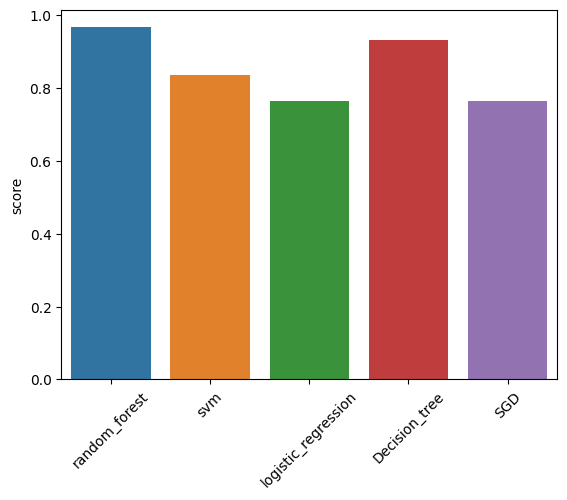

In [48]:
sns.barplot(data = performance,x=performance.index,y='score')
plt.xticks(rotation= 45)
plt.show();

In [49]:
prec_recall = {}
for i in performance.estimator:
    model = i
    model.fit(X_train,y_train)
    y_hat = model.predict(X_test)
    prec_recall[model] = {'Precision': precision_score(y_test,y_hat),'Recall': recall_score(y_test,y_hat)}


In [50]:
prec_recall = [{'Model':model,'Precision':scores['Precision'],'Recall':scores['Recall']} for model, scores in prec_recall.items()]

In [51]:
prec_recall

[{'Model': RandomForestClassifier(max_depth=20, n_estimators=200),
  'Precision': 0.9824797843665768,
  'Recall': 1.0},
 {'Model': SVC(C=10),
  'Precision': 0.8422007255139057,
  'Recall': 0.9554183813443072},
 {'Model': LogisticRegression(C=0.1),
  'Precision': 0.7563291139240507,
  'Recall': 0.8196159122085048},
 {'Model': DecisionTreeClassifier(),
  'Precision': 0.9541884816753927,
  'Recall': 1.0},
 {'Model': SGDClassifier(penalty='l1'),
  'Precision': 0.7375152253349574,
  'Recall': 0.8305898491083676}]

In [52]:
model = ['RandomForest','SVC','LogisticRegression','DecisionTree','SGD']
precRecall = pd.DataFrame(prec_recall).drop(columns='Model')
precRecall.index = model

In [53]:
precRecall

,Precision,Recall
RandomForest,0.982480,1.000000
SVC,0.842201,0.955418
LogisticRegression,0.756329,0.819616
DecisionTree,0.954188,1.000000
SGD,0.737515,0.830590


<Axes: >

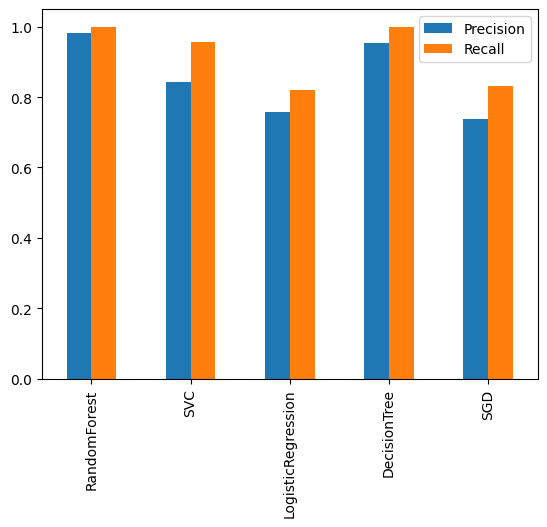

In [54]:
precRecall.plot(kind='bar')

In [55]:
boost_clf = XGBClassifier()

In [57]:
boost_clf.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [58]:
pred = boost_clf.predict(X_test)

In [59]:
accuracy_score(y_test,pred)

0.9722222222222222

In [60]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1458
           1       0.95      1.00      0.97      1458

    accuracy                           0.97      2916
   macro avg       0.97      0.97      0.97      2916
weighted avg       0.97      0.97      0.97      2916



In [61]:
y_prob = boost_clf.predict_proba(X_test)[:,1]

In [62]:
fpr,tpr,thresholds = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

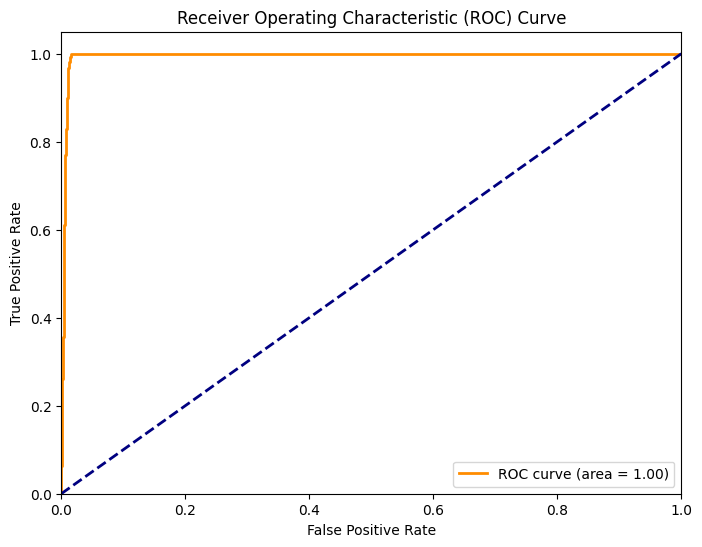

In [63]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,color='darkorange',lw=2,label = f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Params pass to GridSearchCV?

In [64]:
param_grid = {
    'n_estimators': [500,300],            # Number of boosting rounds
    'learning_rate': [0.01, 0.1],    # Step size shrinkage to prevent overfitting
    'reg_alpha': [0.001, 0.01,],           # L1 regularization term on weights
    'reg_lambda': [0.01, 0.1],          # L2 regularization term on weights
}


In [65]:
xg_clf = GridSearchCV(estimator=XGBClassifier(device='gpu'),param_grid=param_grid,cv=4,n_jobs=-1)

In [66]:
xg_clf.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='gpu',
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [500, 300], 'reg_alpha': [0.001, 0.01],
                         'reg_lambda': [0.01, 0.1]})

In [67]:
best_estimator = xg_clf.best_estimator_

In [68]:
pred = best_estimator.predict(X_test)

In [69]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1458
           1       0.95      1.00      0.97      1458

    accuracy                           0.97      2916
   macro avg       0.97      0.97      0.97      2916
weighted avg       0.97      0.97      0.97      2916

